In [209]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import ScalarFormatter
from scipy.stats import genextreme
import random
import xarray

**1. Fitting a generalized extreme value distribution based on annual block maxima based on the Kumasi airport station**

Text(0, 0.5, 'Return level [mm/day]')

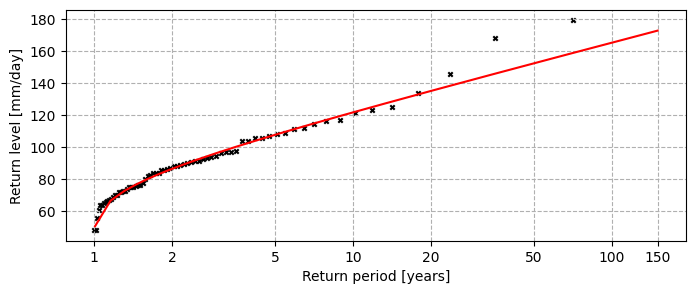

In [210]:
values = [48.0, 48.2, 55.4, 60.5, 64.0, 64.0, 65.0, 65.8, 66.2, 67.1, 67.4,
          69.0, 69.7, 70.3, 71.6, 71.9, 72.4, 72.4, 73.8, 74.9, 75.0, 75.2,
          75.5, 76.4, 76.5, 77.4, 80.0, 81.9, 82.3, 83.6, 83.8, 84.0, 85.3,
          85.9, 86.1, 86.6, 88.0, 88.4, 88.9, 89.6, 90.0, 90.3, 91.4, 91.4,
          92.2, 93.2, 93.5, 94.3, 96.1, 96.8, 97.0, 97.4, 103.4, 103.6,
          105.4, 105.6, 106.9, 108.3, 108.8, 111.5, 111.7, 114.6, 116.3,
          116.6, 121.4, 123.2, 125.2, 133.6, 145.8, 167.9, 179.1]

# Fit the genextreme distribution to the data
params = genextreme.fit(values)

# Generate return periods and corresponding return levels from the fitted distribution
return_periods_theoretical = np.linspace(1.01, 150, 1000)
return_levels_theoretical = genextreme.isf(1 / return_periods_theoretical, *params)

# Calculate empirical return levels
n_years = len(values)  # Number of years with data

# The empirical return period for the largest observation is n_years, for the second largest is n_years/2, etc.
return_periods_empirical = n_years / np.arange(1, n_years + 1)

# Plotting the theoretical and empirical data
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
x_ticks = [1, 2, 5, 10, 20, 50, 100, 150]

ax.plot(return_periods_theoretical, return_levels_theoretical, color="Red")
ax.scatter(return_periods_empirical, values[::-1], color="black", marker="x", s=10)

ax.set_xscale('log', base=2)
ax.set_xticks(x_ticks)
ax.get_xaxis().set_major_formatter(ScalarFormatter())
ax.set_xticklabels([str(x) for x in x_ticks])
ax.grid(True, which="both", ls="--")

ax.set_xlabel("Return period [years]")
ax.set_ylabel("Return level [mm/day]")


**... and calculating the return level [mm/day] for the 100-year return period**

In [211]:
return_value = genextreme.isf(1 / 100, *params)
f"The return level for 100-year daily flood is {return_value.round(2)} mm/day"

june_28_2018 = 114.60

**2. Thinking of disaggregation...**

In [212]:
# function for visualizing
time = pd.date_range("00:00:00", "23:45:00", freq='15T').strftime("%H:%M").tolist()

def plot_vals(time, vals):
    plt.figure(figsize=(8, 4))
    plt.plot(time, np.cumsum(vals), marker='o')
    plt.xticks(time[::8])
    plt.xlabel('Time')
    plt.ylabel('Cumulative Value')
    plt.title('Cumulative Disaggregation over Time')
    plt.grid(True)
    plt.tight_layout()

    plt.figure(figsize=(8, 4))
    plt.plot(time, vals, marker='o')
    plt.xticks(time[::8])
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Disaggregation over Time')
    plt.grid(True)
    plt.tight_layout()

***Uniform Disaggregation***

For uniform disaggregation, we divide the total value evenly across all 15-minute intervals in the 24-hour period.

In [213]:
def uniform_disaggregation(total_value, interval_minutes=15, total_period_hours=24):
    intervals_per_hour = 60 // interval_minutes
    total_intervals = total_period_hours * intervals_per_hour
    value_per_interval = total_value / total_intervals
    disaggregated_values = [value_per_interval] * total_intervals
    return disaggregated_values

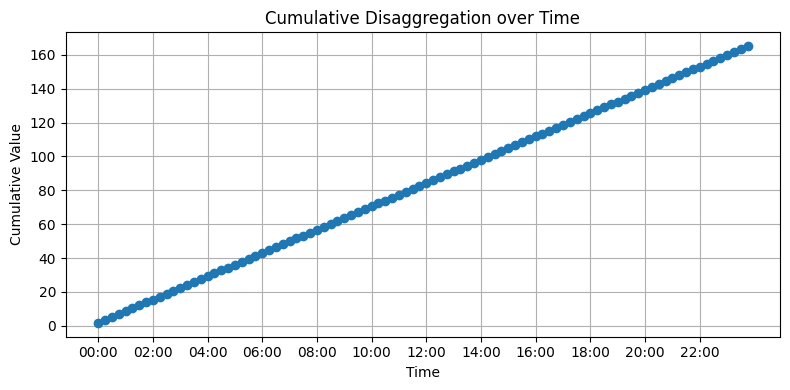

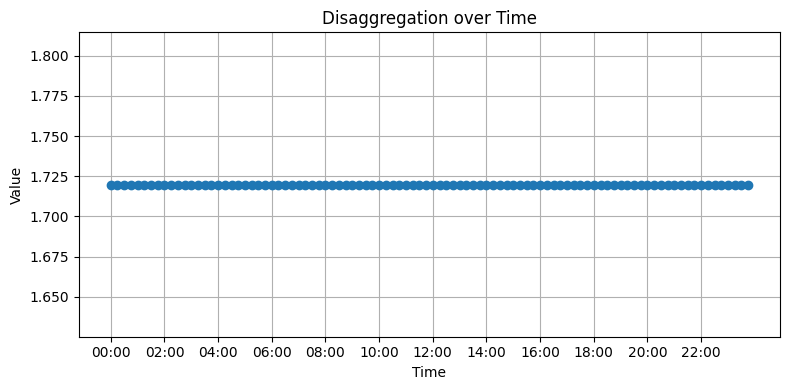

In [214]:
uniform_values = uniform_disaggregation(return_value)
plot_vals(time, uniform_values)

***Random Disaggregation***

For random disaggregation, we distribute the total value across the intervals randomly. We ensure that the sum of all intervals equals the total value.

In [215]:
def random_disaggregation(total_value, interval_minutes=15, total_period_hours=24):
    intervals_per_hour = 60 // interval_minutes
    total_intervals = total_period_hours * intervals_per_hour
    random_values = [random.random() for _ in range(total_intervals)]
    sum_random_values = sum(random_values)
    normalized_values = [value / sum_random_values * total_value for value in random_values]
    return normalized_values


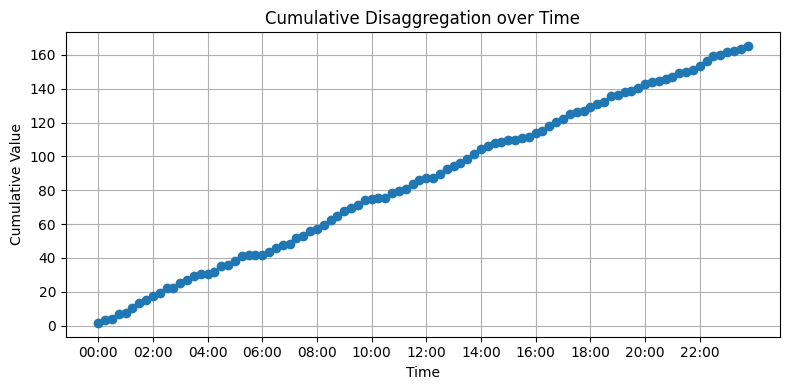

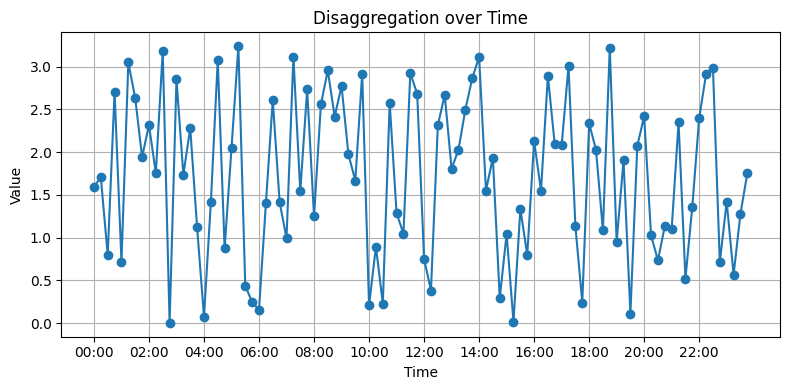

In [216]:
random_values = random_disaggregation(return_value)
plot_vals(time, random_values)

***Random Walk Disaggregation***

In [217]:
def random_walk_disaggregation(total_value, num_intervals=96):
    # Create a random walk
    steps = np.random.normal(0, 1, num_intervals)
    random_walk = np.cumsum(steps)

    # Normalize and apply to total value
    normalized_random_walk = (random_walk - np.min(random_walk))
    normalized_random_walk /= np.sum(normalized_random_walk)
    normalized_random_walk *= total_value
    return normalized_random_walk

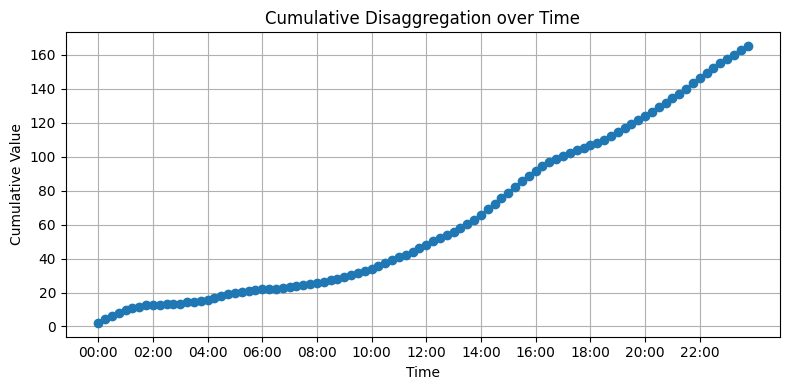

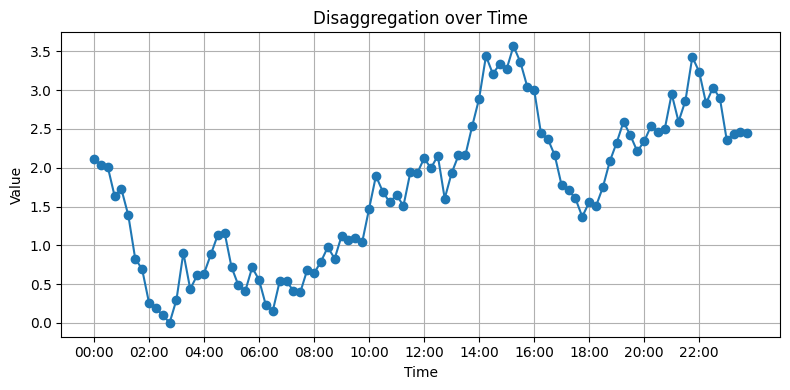

In [218]:
random_walk_values = random_walk_disaggregation(return_value)
plot_vals(time, random_walk_values)

***Spatial Dataset***

In [219]:
# Define boundaries and resolution
lat_start, lat_end, lat_res = 6.00, 6.81, 0.01
lon_start, lon_end, lon_res = -1.67, -1.51, 0.01

latitudes = np.arange(lat_start, lat_end + lat_res, lat_res)
longitudes = np.arange(lon_start, lon_end + lon_res, lon_res)

times = pd.date_range("00:00:00", "23:45:00", freq='15T')

uniform_dat = np.stack([uniform_values] * len(latitudes) * len(longitudes),axis=1).reshape(len(times), len(latitudes), len(longitudes))
random_dat = np.stack([random_values] * len(latitudes) * len(longitudes),axis=1).reshape(len(times), len(latitudes), len(longitudes))
random_walks_dat = np.stack([random_walk_values] * len(latitudes) * len(longitudes),axis=1).reshape(len(times), len(latitudes), len(longitudes))

ds = xarray.Dataset(
    {
        "uniform": (("time", "latitude", "longitude"), uniform_dat),
        "random": (("time", "latitude", "longitude"), random_dat),
        "random_walks": (("time", "latitude", "longitude"), random_walks_dat)
    },
    coords={
        "time": times,
        "latitude": latitudes,
        "longitude": longitudes
    }
)
ds.to_netcdf("kumasi.nc")
